# Deep Learning

## Assignment 2

### Question 2:
### Learning Long Term Dependencies

This part of the assignment looks into the long term dependencies. We need to start by making the the training sets that we will use to train the model. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import sklearn
from torchmetrics.regression import R2Score

p = 100

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def gen_samples(p):
    set1 = torch.zeros(p, p+1)
    set2 = torch.zeros(p, p+1)

    sequence = torch.randint(0, 99, size=(99,))
    sequence = torch.sort(sequence)[0]

    for i in range(len(sequence)):
        set1[i+1, sequence[i]] = 1
        set2[i+1, sequence[i]] = 1

    set1[0, 99] = 1
    set2[0, 100] = 1

    return set1, set2
    

Now that we have made the function which generates our sequences, we can proceed to constructing both the LSTM as well as the RNN models. We will start with a basic structure with just the RNN or LSTM

In [3]:
class MyModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(MyModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x, model):
        if model == 'RNN':
            if len(x[0]) != 1:
                h0 = torch.zeros(self.num_layers, self.hidden_size)
                out, _ = self.rnn(x, h0)
                out = out[-1, :]
                out = self.linear(out)

                return out
    
        
        elif model == 'LSTM':
            if len(x[0]) != 1:
                h0 = torch.zeros(self.num_layers, self.hidden_size)
                c0 = torch.zeros(self.num_layers, self.hidden_size)

                out, (_, _) = self.lstm(x, (h0, c0))
                out = out[-1, :]
                out = self.linear(out)

                return out
        
        return self.inference(x, model)

    def inference(self, x, model):
        if model == 'RNN':
            h0 = torch.zeros(self.num_layers, self.hidden_size)

            input = x
            output_sequence = []

            for _ in range(self.input_size):
                out, hidden = self.rnn(input, h0)
                out = self.linear(out)

                output_sequence.append(out)

                input = out
                h0 = hidden

            return torch.tensor(output_sequence[-1]).view(-1,1)

        if model == 'LSTM':
            h0 = torch.zeros(self.num_layers, self.hidden_size)
            c0 = torch.zeros(self.num_layers, self.hidden_size)

            input = x
            output_sequence = []

            for _ in range(self.input_size):
                out, (h, c) = self.lstm(input, (h0, c0))
                out = self.linear(out)

                output_sequence.append(out)

                input = out
                h0 = h
                c0 = c

            return torch.tensor(output_sequence[-1]).view(-1, 1)
            
            

Above is the mode, architeture where we have implementd bo the LSTM as well as the RNN. We can now observe how both the models work for predicting the sequences above.The parameters are defined in the code below

In [5]:
input_size = p+1
hidden_size = 1000
num_layers = 2

learning_rate = 0.01

model1 = MyModel(input_size, hidden_size, num_layers)
model2 = MyModel(input_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate)

In [6]:
# Generating the training sequences
num_samples = 1000
set1 = torch.zeros(num_samples, p, p+1)
set2 = torch.zeros(num_samples, p, p+1)
for i in range(num_samples):
    set1[i], set2[i] = gen_samples(p)

In [7]:
#Training algorithm for RNN
rnn_loss = []
lstm_loss = []

print('--------RNN TRAINING---------')
for i in range(num_samples):
    int = torch.randint(0, 2, size=(1,))

    if int == 0:
        X_train = set1[i]
    else:
        X_train = set2[i]
    Y_train = p+int[0]-1

    output = model1(X_train, 'RNN')
    output = torch.squeeze(output, dim=0)

    loss = criterion(output, Y_train)

    optimizer1.zero_grad()
    loss.backward()

    optimizer1.step()

    rnn_loss.append(loss.item())

    if (i+1)%100 == 0:
        print(f'epoch {i+1}/{num_samples}, loss  {loss.item():.4f}, set {int[0]}')

#Training algorithm for LSTM
print('--------LSTM TRAINING---------')
for i in range(num_samples):
    int = torch.randint(0, 2, size=(1,))

    if int == 0:
        X_train = set1[i]
    else:
        X_train = set2[i]
    Y_train = p+int[0]-1

    output = model2(X_train, 'LSTM')
    output = torch.squeeze(output, dim=0)

    loss = criterion(output, Y_train)

    optimizer2.zero_grad()
    loss.backward()

    optimizer2.step()

    lstm_loss.append(loss.item())

    if (i+1)%100 == 0:
        print(f'epoch {i+1}/{num_samples}, loss  {loss.item():.4f}, set {int[0]}')

--------RNN TRAINING---------


/home/vedansh/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch 100/1000, loss  0.0000, set 0
epoch 200/1000, loss  3.1839, set 1
epoch 300/1000, loss  0.0006, set 0
epoch 400/1000, loss  0.0499, set 1
epoch 500/1000, loss  0.1060, set 1
epoch 600/1000, loss  7.3417, set 0
epoch 700/1000, loss  1.1992, set 1
epoch 800/1000, loss  0.0000, set 0
epoch 900/1000, loss  30.2083, set 1
epoch 1000/1000, loss  3.0837, set 0
--------LSTM TRAINING---------
epoch 100/1000, loss  0.4256, set 1
epoch 200/1000, loss  0.0010, set 1
epoch 300/1000, loss  0.0463, set 0
epoch 400/1000, loss  0.1420, set 0
epoch 500/1000, loss  0.0331, set 0
epoch 600/1000, loss  0.0194, set 1
epoch 700/1000, loss  0.0533, set 0
epoch 800/1000, loss  0.0125, set 0
epoch 900/1000, loss  0.0370, set 1
epoch 1000/1000, loss  0.0059, set 0


Now that we have trained our 2 seperate models being the RNN and LSTM respectively let us plot the errors with the epochs

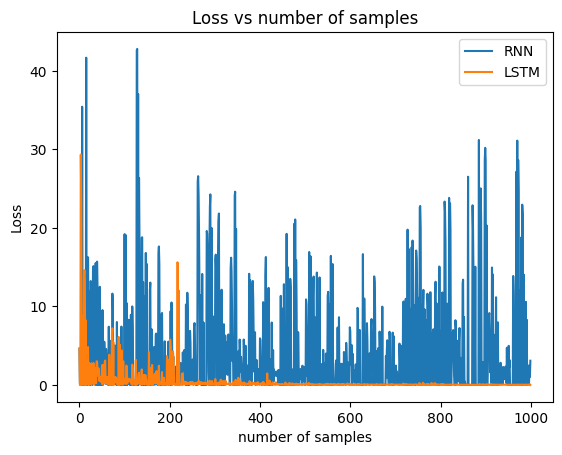

In [8]:
plt.plot(range(num_samples), rnn_loss, label = 'RNN')
plt.plot(range(num_samples), lstm_loss, label='LSTM')
plt.xlabel('number of samples')
plt.ylabel('Loss')
plt.title('Loss vs number of samples')
plt.legend()
plt.show()

As we can see, the lstm model learnt the dependency and has understood that the output is to be the same as the input symbol to the sequence. Meanwhile, RNNs are not able to learn this dependancy and fail to recognise the actual output of the sequence.

In [9]:
with torch.no_grad():

    for k in range(10):
        num_test = 3000
        set1 = torch.zeros(num_test, p, p+1)
        set2 = torch.zeros(num_test, p, p+1)
        for i in range(num_test):
            set1[i], set2[i] = gen_samples(p)

        num_correct_rnn = 0.0
        num_correct_lstm = 0.0
        for i in range(num_test):
            
            output_rnn = model1(set1[i][0].view(1, -1), 'RNN')
            output_lstm = model2(set1[i][0].view(1, -1), 'LSTM')
            
            _, predictions_rnn = torch.max(output_rnn, 0)
            num_correct_rnn += 1 if predictions_rnn==99 else 0

            _, predictions_lstm = torch.max(output_lstm, 0)
            num_correct_lstm += 1 if predictions_lstm==99 else 0

        print(f'Trial {k+1}/10, Average correct for RNN: {num_correct_rnn}/3000, Average correct for lstm: {num_correct_lstm}/3000')



Trial 1/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 2/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 3/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 4/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 5/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 6/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 7/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 8/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 9/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
Trial 10/10, Average correct for RNN: 0.0/3000, Average correct for lstm: 0.0/3000
